# 230725 Filter VCF variant calls with ML

## Load VCF files

In [1]:
library(VariantAnnotation)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    co

In [2]:
# load GIAB truth set VCF
vcf_to_read <- '~/ERR1831349/06_vcf_snps_only_GIAB_WXS_isec/NA12878_GIAB_WXS_snps_only.vcf'
(GIAB_vcf <- readVcf(vcf_to_read))

class: CollapsedVCF 
dim: 32806 1 
rowRanges(vcf):
  GRanges with 5 metadata columns: paramRangeID, REF, ALT, QUAL, FILTER
info(vcf):
  DataFrame with 16 columns: DPSum, platforms, platformnames, platformbias, ...
info(header(vcf)):
                                   Number Type    Description                  
   DPSum                           1      Integer Total read depth summed ac...
   platforms                       1      Integer Number of different platfo...
   platformnames                   .      String  Names of platforms for whi...
   platformbias                    .      String  Names of platforms that ha...
   datasets                        1      Integer Number of different datase...
   datasetnames                    .      String  Names of datasets for whic...
   datasetsmissingcall             .      String  Names of datasets that are...
   callsets                        1      Integer Number of different callse...
   callsetnames                    .      Strin

In [3]:
# load test sample vcf
vcf_to_read <- '~/ERR1831349/06_vcf_snps_only_GIAB_WXS_isec/ERR1831349_markdup_bcftools_P_099_snps_only_GIAB_WXS_isec.vcf'
(bcftools_P_0.99_vcf <- readVcf(vcf_to_read))

class: CollapsedVCF 
dim: 34676 1 
rowRanges(vcf):
  GRanges with 5 metadata columns: paramRangeID, REF, ALT, QUAL, FILTER
info(vcf):
  DataFrame with 17 columns: INDEL, IDV, IMF, DP, VDB, RPBZ, MQBZ, BQBZ, MQS...
info(header(vcf)):
         Number Type    Description                                            
   INDEL 0      Flag    Indicates that the variant is an INDEL.                
   IDV   1      Integer Maximum number of raw reads supporting an indel        
   IMF   1      Float   Maximum fraction of raw reads supporting an indel      
   DP    1      Integer Raw read depth                                         
   VDB   1      Float   Variant Distance Bias for filtering splice-site arte...
   RPBZ  1      Float   Mann-Whitney U-z test of Read Position Bias (closer ...
   MQBZ  1      Float   Mann-Whitney U-z test of Mapping Quality Bias (close...
   BQBZ  1      Float   Mann-Whitney U-z test of Base Quality Bias (closer t...
   MQSBZ 1      Float   Mann-Whitney U-z test o

In [4]:
# create vectors with SNP 'names'

GIAB_snps <- rownames(rowData(GIAB_vcf[isSNV(GIAB_vcf)]))
bcftools_P_0.99_snps <- rownames(rowData(bcftools_P_0.99_vcf[isSNV(bcftools_P_0.99_vcf)]))

In [5]:
# Venn Diagrams
library(VennDiagram)

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern


Loading required package: futile.logger



In [6]:
# stats for Venn Diagram for bcftools_P_0.99 and GIAB

bcftools_P_0.99_ONLY <- setdiff(bcftools_P_0.99_snps, GIAB_snps)
GIAB_ONLY <- setdiff(GIAB_snps, bcftools_P_0.99_snps)
BOTH_bcftools_P_0.99_GIAB <- intersect(bcftools_P_0.99_snps, GIAB_snps)

str(bcftools_P_0.99_ONLY)
str(GIAB_ONLY)
str(BOTH_bcftools_P_0.99_GIAB)

 chr [1:3126] "chr10:689574_G/A" "chr10:1184801_C/G" "chr10:1184882_C/T" ...
 chr [1:1257] "chr1:942451_T/C" "chr1:2491175_G/A" "chr1:2502461_C/T" ...
 chr [1:31536] "chr10:236957_C/T" "chr10:249013_A/G" "chr10:349326_T/C" ...


In [7]:
# increase size of plots from default
options(repr.plot.width = 14, 
        repr.plot.height = 14) # from 7, 7

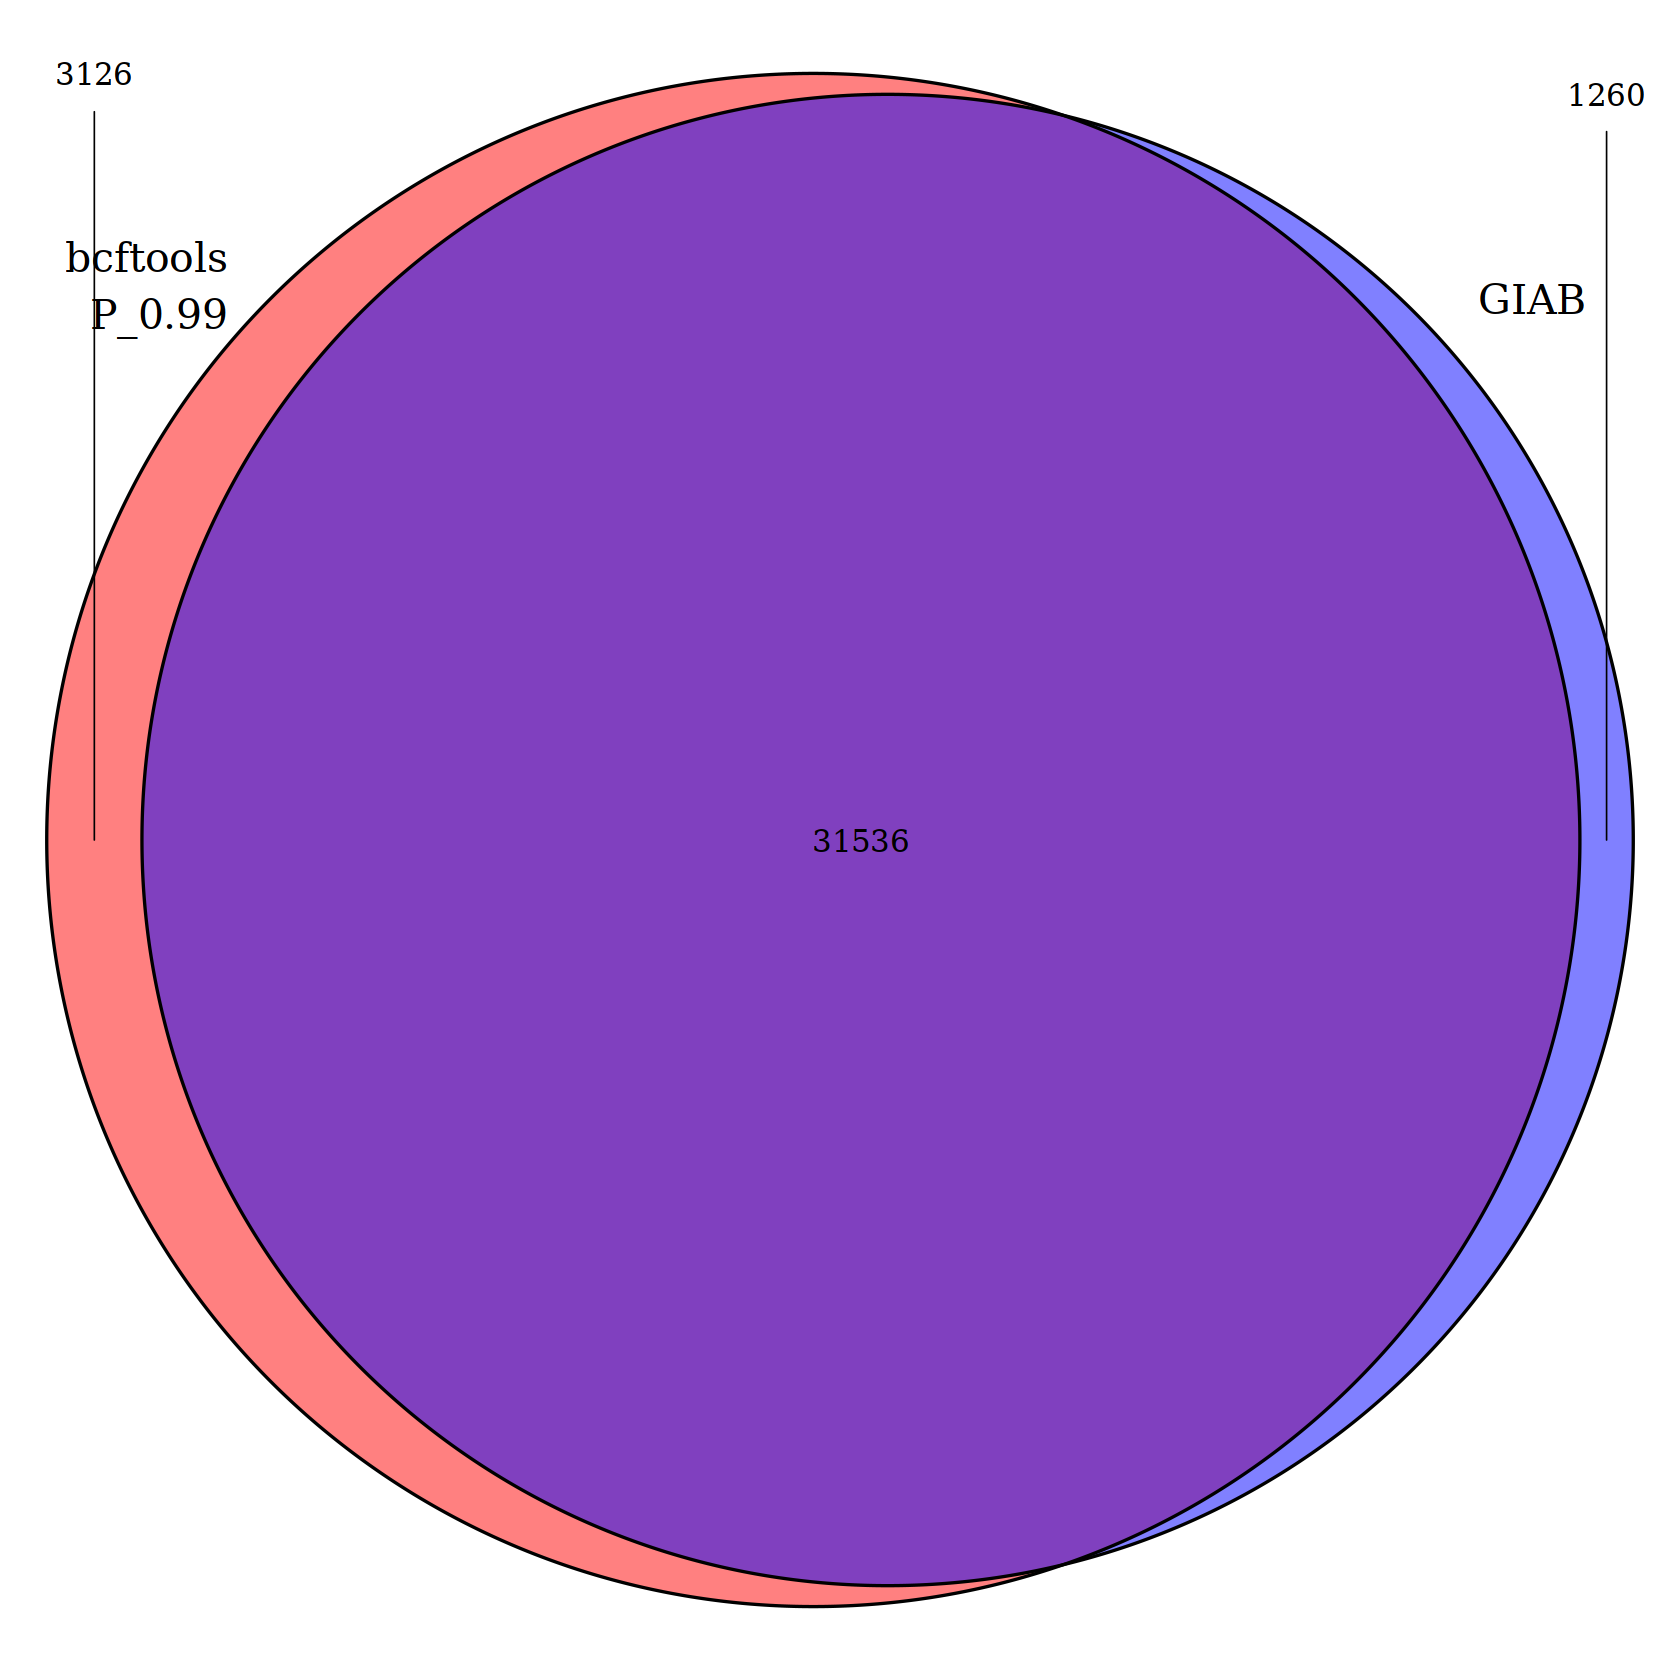

In [8]:
# draw Venn Diagram for bcftools_P_0.99 and GIAB

venn.plot <- draw.pairwise.venn(length(bcftools_P_0.99_snps), length(GIAB_snps), length(BOTH_bcftools_P_0.99_GIAB), 
                                c('bcftools \n P_0.99', 'GIAB'), fill = c('red', 'blue'), 
                                ext.percent = rep(0.1, 3), cex = rep(1.5, 3), cat.cex = rep(2, 2))

In [9]:
# https://en.wikipedia.org/wiki/Receiver_operating_characteristic

# FP/(FP + TP) = 1 - precision
paste('false discovery rate (FP artifacts): ', round(length(bcftools_P_0.99_ONLY)/length(bcftools_P_0.99_snps), 3))
paste('precision: ', round(1 - length(bcftools_P_0.99_ONLY)/length(bcftools_P_0.99_snps), 3))

# sensitivity, recall, hit rate, or true positive rate (TPR) = TP/P = TP/(TP + FN)
paste('sensitivity: ', round(length(BOTH_bcftools_P_0.99_GIAB)/length(GIAB_snps), 3))
paste('false negative rate (FN artifacts): ', 1 - round(length(BOTH_bcftools_P_0.99_GIAB)/length(GIAB_snps), 3))

# F1 score = 2 * (precision * sensitivity)/(precision + sensitivity)
precision <- 1 - length(bcftools_P_0.99_ONLY)/length(bcftools_P_0.99_snps)
sensitivity <- length(BOTH_bcftools_P_0.99_GIAB)/length(GIAB_snps)
paste('F1 score: ', round(2 * (precision * sensitivity)/(precision + sensitivity), 3))

[1] "false discovery rate (FP artifacts):  0.09"

[1] "precision:  0.91"

[1] "sensitivity:  0.962"

[1] "false negative rate (FN artifacts):  0.038"

[1] "F1 score:  0.935"

## Create dataframe for ML model

In [10]:
x <- rowRanges(bcftools_P_0.99_vcf)

system.time({
    x_df <- data.frame(x)
})

   user  system elapsed 
 68.063   0.347  68.420 

In [11]:
head(x_df)

,seqnames,start,end,width,strand,paramRangeID,REF,ALT,QUAL,FILTER
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<chr>,<list>,<dbl>,<chr>
1,chr10,236957,236957,1,*,NA,C,T,254.960,PASS
2,chr10,249013,249013,1,*,NA,A,G,254.960,PASS
3,chr10,349326,349326,1,*,NA,T,C,254.960,PASS
4,chr10,382563,382563,1,*,NA,A,G,254.960,PASS
5,chr10,399121,399121,1,*,NA,C,T,254.960,PASS
6,chr10,414000,414000,1,*,NA,G,A,251.944,PASS


In [12]:
# select SNVs only
my_vcf_snv <- isSNV(bcftools_P_0.99_vcf) # logical T/F
GIAB_NA12878_vcf_snv <- isSNV(GIAB_vcf) # logical T/F

In [13]:
# create vectors with names of SNVs e.g. "chr1:826893_G/A"
my_vcf_snvs_only <- rownames(rowData(bcftools_P_0.99_vcf))[my_vcf_snv]
GIAB_NA12878_vcf_snvs_only <- rownames(rowData(GIAB_vcf))[GIAB_NA12878_vcf_snv]
str(my_vcf_snvs_only)
str(GIAB_NA12878_vcf_snvs_only)

 chr [1:34662] "chr10:236957_C/T" "chr10:249013_A/G" "chr10:349326_T/C" ...
 chr [1:32796] "chr1:826893_G/A" "chr1:941119_A/G" "chr1:942335_C/G" ...


In [14]:
# create target vector "y" to be used for ML modeling
# labels: FALSE is potential artifact
y <- my_vcf_snvs_only %in% GIAB_NA12878_vcf_snvs_only
table(y)
table(y)[1]/sum(table(y))

y
FALSE  TRUE 
 3126 31536 

FALSE 
0.09018522

- about 9% of the calls in the vcf are FALSE POSITIVES
- goal of ML modeling: minimize this i.e. filter out as many false positives as possible

In [15]:
# create dataframe for ML
z0 <- x_df[my_vcf_snv, c('REF', 'ALT', 'QUAL')]
z0[['ALT']] <- sapply(z0[['ALT']], as.character)
# "Raw read depth" "Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)" 
# "Segregation based metric." "Fraction of MQ0 reads (smaller is better)" "Average mapping quality"
z1 <- info(bcftools_P_0.99_vcf)[my_vcf_snv, c('DP', "VDB", "SGB", "MQ0F", "MQ")]
# DP4 - Number of high-quality ref-forward , ref-reverse, alt-forward and alt-reverse bases
z2 <- as.matrix(info(bcftools_P_0.99_vcf)[my_vcf_snv, "DP4"])
colnames(z2) <- c('DP4_1', 'DP4_2', 'DP4_3', 'DP4_4')
z <- data.frame(y, z0, z1, z2)
z <- droplevels(z)
head(z)

,y,REF,ALT,QUAL,DP,VDB,SGB,MQ0F,MQ,DP4_1,DP4_2,DP4_3,DP4_4
,<lgl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,TRUE,C,T,254.960,61,0.2154330,-0.693147,0,60,0,0,13,48
2,TRUE,A,G,254.960,52,0.9537080,-0.693147,0,60,0,0,20,30
3,TRUE,T,C,254.960,26,0.4650320,-0.692976,0,60,0,0,24,2
4,TRUE,A,G,254.960,26,0.2147990,-0.692914,0,60,0,0,21,4
5,TRUE,C,T,254.960,60,0.0226066,-0.693147,0,60,0,0,39,20
6,TRUE,G,A,251.944,38,0.5248080,-0.692067,0,60,9,9,11,9


In [16]:
# add feature that is REF and ALT concatenated
z$REF_ALT <- paste(z$REF, z$ALT, sep = "_")
head(z)

,y,REF,ALT,QUAL,DP,VDB,SGB,MQ0F,MQ,DP4_1,DP4_2,DP4_3,DP4_4,REF_ALT
,<lgl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>
1,TRUE,C,T,254.960,61,0.2154330,-0.693147,0,60,0,0,13,48,C_T
2,TRUE,A,G,254.960,52,0.9537080,-0.693147,0,60,0,0,20,30,A_G
3,TRUE,T,C,254.960,26,0.4650320,-0.692976,0,60,0,0,24,2,T_C
4,TRUE,A,G,254.960,26,0.2147990,-0.692914,0,60,0,0,21,4,A_G
5,TRUE,C,T,254.960,60,0.0226066,-0.693147,0,60,0,0,39,20,C_T
6,TRUE,G,A,251.944,38,0.5248080,-0.692067,0,60,9,9,11,9,G_A


In [17]:
z <- z[c(1:3, 14, 4:13)]
head(z)

,y,REF,ALT,REF_ALT,QUAL,DP,VDB,SGB,MQ0F,MQ,DP4_1,DP4_2,DP4_3,DP4_4
,<lgl>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,TRUE,C,T,C_T,254.960,61,0.2154330,-0.693147,0,60,0,0,13,48
2,TRUE,A,G,A_G,254.960,52,0.9537080,-0.693147,0,60,0,0,20,30
3,TRUE,T,C,T_C,254.960,26,0.4650320,-0.692976,0,60,0,0,24,2
4,TRUE,A,G,A_G,254.960,26,0.2147990,-0.692914,0,60,0,0,21,4
5,TRUE,C,T,C_T,254.960,60,0.0226066,-0.693147,0,60,0,0,39,20
6,TRUE,G,A,G_A,251.944,38,0.5248080,-0.692067,0,60,9,9,11,9


In [18]:
# convert y to factor
z$y <- as.factor(z$y)
head(z)

,y,REF,ALT,REF_ALT,QUAL,DP,VDB,SGB,MQ0F,MQ,DP4_1,DP4_2,DP4_3,DP4_4
,<fct>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,TRUE,C,T,C_T,254.960,61,0.2154330,-0.693147,0,60,0,0,13,48
2,TRUE,A,G,A_G,254.960,52,0.9537080,-0.693147,0,60,0,0,20,30
3,TRUE,T,C,T_C,254.960,26,0.4650320,-0.692976,0,60,0,0,24,2
4,TRUE,A,G,A_G,254.960,26,0.2147990,-0.692914,0,60,0,0,21,4
5,TRUE,C,T,C_T,254.960,60,0.0226066,-0.693147,0,60,0,0,39,20
6,TRUE,G,A,G_A,251.944,38,0.5248080,-0.692067,0,60,9,9,11,9


In [19]:
summary(z)

     y             REF                ALT              REF_ALT         
 FALSE: 3126   Length:34662       Length:34662       Length:34662      
 TRUE :31536   Class :character   Class :character   Class :character  
               Mode  :character   Mode  :character   Mode  :character  
                                                                       
                                                                       
                                                                       
                                                                       
      QUAL               DP              VDB              SGB         
 Min.   :  3.368   Min.   :  1.00   Min.   :0.0000   Min.   :-0.6931  
 1st Qu.:199.858   1st Qu.: 25.00   1st Qu.:0.2802   1st Qu.:-0.6931  
 Median :251.905   Median : 42.00   Median :0.5638   Median :-0.6930  
 Mean   :210.174   Mean   : 46.74   Mean   :0.5438   Mean   :-0.6601  
 3rd Qu.:254.960   3rd Qu.: 64.00   3rd Qu.:0.8203   3rd Qu.:-0.6864 

In [20]:
# drop feature VDB since has NA's
z <- subset(z, select = -c(VDB))
head(z)

,y,REF,ALT,REF_ALT,QUAL,DP,SGB,MQ0F,MQ,DP4_1,DP4_2,DP4_3,DP4_4
,<fct>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,TRUE,C,T,C_T,254.960,61,-0.693147,0,60,0,0,13,48
2,TRUE,A,G,A_G,254.960,52,-0.693147,0,60,0,0,20,30
3,TRUE,T,C,T_C,254.960,26,-0.692976,0,60,0,0,24,2
4,TRUE,A,G,A_G,254.960,26,-0.692914,0,60,0,0,21,4
5,TRUE,C,T,C_T,254.960,60,-0.693147,0,60,0,0,39,20
6,TRUE,G,A,G_A,251.944,38,-0.692067,0,60,9,9,11,9


In [21]:
# drop REF & ALT and just use REF_ALT
z <- subset(z, select = -c(REF, ALT))
head(z)

,y,REF_ALT,QUAL,DP,SGB,MQ0F,MQ,DP4_1,DP4_2,DP4_3,DP4_4
,<fct>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,TRUE,C_T,254.960,61,-0.693147,0,60,0,0,13,48
2,TRUE,A_G,254.960,52,-0.693147,0,60,0,0,20,30
3,TRUE,T_C,254.960,26,-0.692976,0,60,0,0,24,2
4,TRUE,A_G,254.960,26,-0.692914,0,60,0,0,21,4
5,TRUE,C_T,254.960,60,-0.693147,0,60,0,0,39,20
6,TRUE,G_A,251.944,38,-0.692067,0,60,9,9,11,9


## Fit Logistic Regression

In [22]:
library(caret)

Warning message:
“package ‘caret’ was built under R version 4.2.3”
Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Loading required package: lattice

Warning message:
“package ‘lattice’ was built under R version 4.2.3”


In [23]:
packageVersion("caret")

[1] ‘6.0.94’

In [24]:
print(levels(z$y))

[1] "FALSE" "TRUE" 


In [25]:
# rename levels of z to 'artifact' and 'genuine'

# View the current levels of the 'y' column
print(levels(z$y))

# Rename the levels
levels(z$y) <- c("artifact", "genuine")

# View the updated levels of the 'y' column
print(levels(z$y))

[1] "FALSE" "TRUE" 
[1] "artifact" "genuine" 


In [26]:
# logistic regression 10-fold CV 10 times
set.seed(23832)

# create stratified folds (10-fold CV repeated 10 times)
folds <- createMultiFolds(z$y, 
                          k = 10, 
                          times = 10)

train.control <- trainControl(method = "repeatedcv", 
                              index = folds, 
                              classProbs = TRUE, 
                              summaryFunction = twoClassSummary) # 10-fold CV repeated 10 times

ptm <- proc.time()
model.logreg <- train(y ~ ., data = z,
                        trControl = train.control,
                        method = 'glm',
                        family = 'binomial', 
                      metric = "F1")
proc.time() - ptm
summary(model.logreg)

Warning message in train.default(x, y, weights = w, ...):
“The metric "F1" was not in the result set. ROC will be used instead.”


   user  system elapsed 
405.485 801.239  71.357 


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.3552   0.0003   0.0016   0.0064   3.9196  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -13.567263   1.351016 -10.042  < 2e-16 ***
REF_ALTA_G    1.293601   0.323706   3.996 6.44e-05 ***
REF_ALTA_T    0.710579   0.540735   1.314   0.1888    
REF_ALTC_A    0.743773   0.413185   1.800   0.0718 .  
REF_ALTC_G    0.798882   0.383426   2.084   0.0372 *  
REF_ALTC_T    1.957768   0.329797   5.936 2.92e-09 ***
REF_ALTG_A    1.288546   0.322485   3.996 6.45e-05 ***
REF_ALTG_C    0.773810   0.359409   2.153   0.0313 *  
REF_ALTG_T    0.918941   0.444633   2.067   0.0388 *  
REF_ALTT_A    0.732081   0.529405   1.383   0.1667    
REF_ALTT_C    0.761458   0.322232   2.363   0.0181 *  
REF_ALTT_G   -0.860725   0.406189  -2.119   0.0341 *  
QUAL          0.059025   0.002465  23.950  < 2e-16 ***
DP           -0.080911   0.039503  -2.048   0.0405 *  
SGB         -16.336412   0.875669 

In [27]:
model.logreg$results

,parameter,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,0.9979986,0.9720406,0.994454,0.0009959812,0.009325628,0.001244577
